## NLP & SMS Spam Classification

In [ ]:
! pip install unidecode

In [ ]:
# imports
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import seaborn as sns
import time
from timeit import timeit
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)
from textblob import TextBlob
from unidecode import unidecode

In [ ]:
from datasets import load_dataset

# Load the dataset from Hugging Face
ds = load_dataset("ucirvine/sms_spam")

ds

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})

In [ ]:
df = pd.DataFrame(ds['train'])
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,1
3,U dun say so early hor... U c already then say...\n,0
4,"Nah I don't think he goes to usf, he lives around here though\n",0


In [ ]:
df.label.value_counts(normalize=True)

,proportion
label,
0,0.865985
1,0.134015


## Preprocessing

In [ ]:
import re
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
import nltk
nltk.data.path.append("C:/Users/HP/AppData/Roaming/nltk_data")

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


def preprocess(text):
  text = text.lower()
  #text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text) # remove URLs
  #text = re.sub('<.*?>', '', text)   # remove HTML tags
  text = re.sub(r'[^\w\s]', '', text) # remove punc
  text = re.sub(r'\d+','',text)# remove numbers
  #text = re.sub(r"[.?!]", '', text)
  #text = re.sub('[0-9]+', '', text)
  #text = re.sub('@(\w+)',"", text ) # remove usernames
  text = re.sub(r"[#|_]", '', text) # remove the # in #hashtag
  text = word_tokenize(text) # remove repeated characters (helloooooooo into hello)

  #removing stopwords and puncuations
  mystopword = set(nltk.corpus.stopwords.words('english') + ['URL'])
  text = [word for word in text if word not in mystopword]
  text = [word for word in text if word not in punctuation]

  # mystopwords = set(stopwords.words('english') + list(punctuation) + ['URL'])

  #apply lemmatizing
  # wn = nltk.WordNetLemmatizer()
  # text = [wn.lemmatize(word) for word in text]


  # #apply stemming
  # ps = nltk.PorterStemmer()
  # text = [ps.stem(word) for word in text]

  return text


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
print(preprocess(df['sms'][2]))

['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'questionstd', 'txt', 'ratetcs', 'apply', 'overs']


In [ ]:
# clean sms messages
%time df['clean_sms'] = df['sms'].apply(lambda x: preprocess(x))

CPU times: user 1.39 s, sys: 109 ms, total: 1.5 s
Wall time: 2.28 s


In [ ]:
# join tokens back to string
%time df['clean_sms'] = df['clean_sms'].apply(lambda x: ' '.join([str(i) for i in x]))

CPU times: user 13.4 ms, sys: 0 ns, total: 13.4 ms
Wall time: 25 ms


In [ ]:
df.head()

,sms,label,clean_sms
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",0,go jurong point crazy available bugis n great world la e buffet cine got amore wat
1,Ok lar... Joking wif u oni...\n,0,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,1,free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs ...
3,U dun say so early hor... U c already then say...\n,0,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives around here though\n",0,nah dont think goes usf lives around though


In [ ]:
# remove empty rows
df = df[df["clean_sms"].astype(str).str.len()!=0]

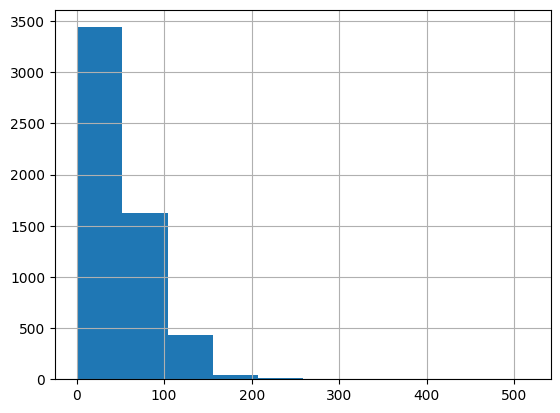

,0
count,5568.000000
mean,51.265625
std,38.962009
min,1.000000
25%,22.000000
50%,39.000000
75%,76.000000
max,516.000000


In [ ]:
sms_len = [len(x) for x in df['clean_sms']]
pd.Series(sms_len).hist()
plt.show()
pd.Series(sms_len).describe()

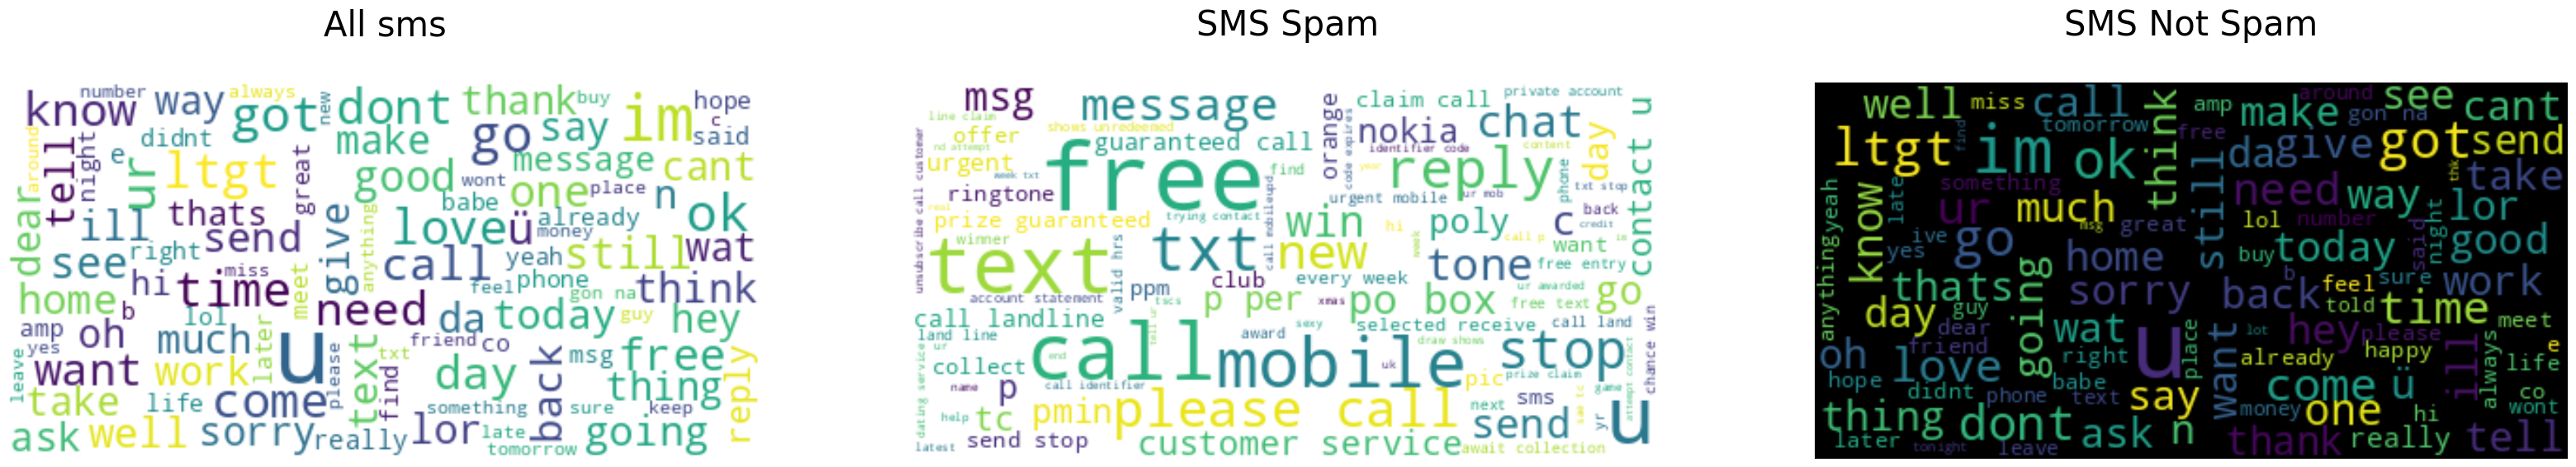

CPU times: user 2.37 s, sys: 85.8 ms, total: 2.45 s
Wall time: 2.86 s


In [ ]:
%%time

from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
# Start with one message:
df_spam = df[df['label']==1]
df_ham = df[df['label']==0]
sms_All = " ".join(message for message in df.clean_sms)
sms_pos = " ".join(message for message in df_spam.clean_sms)
sms_neg = " ".join(message for message in df_ham.clean_sms)

fig, ax = plt.subplots(1, 3, figsize  = (40,40))

# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(sms_All)
wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(sms_pos)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(sms_neg)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All sms\n', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_pos, interpolation='bilinear')
ax[1].set_title('SMS Spam\n',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_neg, interpolation='bilinear')
ax[2].set_title('SMS Not Spam\n',fontsize=30)
ax[2].axis('off')
plt.show()

## Train/Test Split

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

texts = df['clean_sms']
labels = df['label']
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)

## Logistic Regression Using Bag of Words N-Grams (Count Vectorization)

In [ ]:
# Unigram Model
vec_uni = CountVectorizer(ngram_range=(1,1))
X_uni = vec_uni.fit_transform(X_train)
X_uni_test = vec_uni.transform(X_test)

clf_uni = LogisticRegression(max_iter=200)
clf_uni.fit(X_uni, y_train)
pred_uni = clf_uni.predict(X_uni_test)
print(classification_report(y_test, pred_uni))
print("Accuracy:", accuracy_score(y_test, pred_uni))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       1.00      0.85      0.92       149

    accuracy                           0.98      1114
   macro avg       0.99      0.93      0.95      1114
weighted avg       0.98      0.98      0.98      1114

Accuracy: 0.9802513464991023


In [ ]:
# Unigram + Bigram Model
vec_bi = CountVectorizer(ngram_range=(1,2))
X_bi = vec_bi.fit_transform(X_train)
X_bi_test = vec_bi.transform(X_test)

clf_bi = LogisticRegression(max_iter=200)
clf_bi.fit(X_bi, y_train)
pred_bi = clf_bi.predict(X_bi_test)
print(classification_report(y_test, pred_bi))
print("Accuracy:", accuracy_score(y_test, pred_bi))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       1.00      0.82      0.90       149

    accuracy                           0.98      1114
   macro avg       0.99      0.91      0.94      1114
weighted avg       0.98      0.98      0.97      1114

Accuracy: 0.9757630161579892


In [ ]:
# Unigram + Bigram + Trigram Model
vec_tri = CountVectorizer(ngram_range=(1,3))
X_tri = vec_tri.fit_transform(X_train)
X_tri_test = vec_tri.transform(X_test)

clf_tri = LogisticRegression(max_iter=200)
clf_tri.fit(X_tri, y_train)
pred_tri = clf_tri.predict(X_tri_test)
print(classification_report(y_test, pred_tri))
print("Accuracy:", accuracy_score(y_test, pred_tri))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       1.00      0.80      0.89       149

    accuracy                           0.97      1114
   macro avg       0.98      0.90      0.94      1114
weighted avg       0.97      0.97      0.97      1114

Accuracy: 0.9730700179533214


## Logistic Regression Using TFIDF Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Unigram
vec_tfidf_uni = TfidfVectorizer(ngram_range=(1,1))
# Unigram + Bigram
vec_tfidf_bi = TfidfVectorizer(ngram_range=(1,2))
# Unigram + Bigram + Trigram
vec_tfidf_tri = TfidfVectorizer(ngram_range=(1,3))

In [ ]:
# Unigram Model
X_tfidf_uni = vec_tfidf_uni.fit_transform(X_train)
X_tfidf_uni_test = vec_tfidf_uni.transform(X_test)
clf_tfidf_uni = LogisticRegression(max_iter=200)
clf_tfidf_uni.fit(X_tfidf_uni, y_train)
pred_tfidf_uni = clf_tfidf_uni.predict(X_tfidf_uni_test)
print(classification_report(y_test, pred_tfidf_uni))
print("Accuracy:", accuracy_score(y_test, pred_tfidf_uni))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       0.99      0.72      0.84       149

    accuracy                           0.96      1114
   macro avg       0.98      0.86      0.91      1114
weighted avg       0.96      0.96      0.96      1114

Accuracy: 0.9622980251346499


In [ ]:
# Unigram + Bigram Model
X_tfidf_uni = vec_tfidf_bi.fit_transform(X_train)
X_tfidf_uni_test = vec_tfidf_bi.transform(X_test)
clf_tfidf_uni = LogisticRegression(max_iter=200)
clf_tfidf_uni.fit(X_tfidf_uni, y_train)
pred_tfidf_uni = clf_tfidf_uni.predict(X_tfidf_uni_test)
print(classification_report(y_test, pred_tfidf_uni))
print("Accuracy:", accuracy_score(y_test, pred_tfidf_uni))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       0.98      0.70      0.82       149

    accuracy                           0.96      1114
   macro avg       0.97      0.85      0.90      1114
weighted avg       0.96      0.96      0.96      1114

Accuracy: 0.9587073608617595


In [ ]:
# Unigram + Bigram + Trigram Model
X_tfidf_uni = vec_tfidf_tri.fit_transform(X_train)
X_tfidf_uni_test = vec_tfidf_tri.transform(X_test)
clf_tfidf_uni = LogisticRegression(max_iter=200)
clf_tfidf_uni.fit(X_tfidf_uni, y_train)
pred_tfidf_uni = clf_tfidf_uni.predict(X_tfidf_uni_test)
print(classification_report(y_test, pred_tfidf_uni))
print("Accuracy:", accuracy_score(y_test, pred_tfidf_uni))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.99      0.62      0.77       149

    accuracy                           0.95      1114
   macro avg       0.97      0.81      0.87      1114
weighted avg       0.95      0.95      0.94      1114

Accuracy: 0.9488330341113106


## LSTM For NLP Using Self Learned Embeddings

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from collections import Counter
import re
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
import nltk

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
    # Form a vocabulary of all the words

    word_list = []
    # stop_words = set(stopwords.words('english'))
    stop_words = []
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}



    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = y_train
    encoded_test = y_val
    return final_list_train,encoded_train,final_list_test,encoded_test,onehot_dict

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
X_train_tok,y_train_tok,X_test_tok,y_test_tok,vocab = tokenize(X_train,y_train,X_test,y_test)

In [ ]:
vocab

{'u': 1,
 'call': 2,
 'im': 3,
 'get': 4,
 'ur': 5,
 'go': 6,
 'ltgt': 7,
 'dont': 8,
 'free': 9,
 'ok': 10,
 'got': 11,
 'know': 12,
 'good': 13,
 'ill': 14,
 'day': 15,
 'like': 16,
 'come': 17,
 'want': 18,
 'time': 19,
 'text': 20,
 'love': 21,
 'send': 22,
 'need': 23,
 'ü': 24,
 'going': 25,
 'txt': 26,
 'home': 27,
 'one': 28,
 'lor': 29,
 'n': 30,
 'r': 31,
 'stop': 32,
 'back': 33,
 'still': 34,
 'reply': 35,
 'see': 36,
 'sorry': 37,
 'tell': 38,
 'today': 39,
 'later': 40,
 'new': 41,
 'take': 42,
 'da': 43,
 'well': 44,
 'please': 45,
 'hi': 46,
 'mobile': 47,
 'think': 48,
 'cant': 49,
 'claim': 50,
 'phone': 51,
 'great': 52,
 'much': 53,
 'oh': 54,
 'dear': 55,
 'hey': 56,
 'week': 57,
 'night': 58,
 'hope': 59,
 'na': 60,
 'way': 61,
 'pls': 62,
 'happy': 63,
 'thats': 64,
 'give': 65,
 'wat': 66,
 'already': 67,
 'wan': 68,
 'make': 69,
 'right': 70,
 'tomorrow': 71,
 'message': 72,
 'really': 73,
 'work': 74,
 'yes': 75,
 'e': 76,
 'say': 77,
 'number': 78,
 'didnt': 

In [ ]:
X_train[5:10]

,clean_sms
3994,nimbomsons yep phone knows one obviously cos thats real word
1316,whenevr ur sad whenevr ur gray remembr im listn watevr u wan na say jus walk wid little whileamp...
493,sorryin meeting ill call later
3850,u town alone
4380,checking


In [ ]:
X_train_tok[5:10]

[[3343, 1041, 51, 828, 28, 1700, 91, 64, 260, 335],
 [2201,
  5,
  405,
  2201,
  5,
  3344,
  3345,
  3,
  3346,
  3347,
  1,
  68,
  60,
  77,
  217,
  406,
  428,
  261,
  3348,
  829,
  14,
  377,
  33,
  5,
  226],
 [2202, 209, 14, 2, 40],
 [1, 349, 543],
 [830]]

In [ ]:
idx_word = {value:key for key,value in vocab.items()}
for idx in [100, 67, 100, 5264, 11, 3, 153, 5265, 2976, 14, 1281]:
  print(idx_word[idx])

find
already
find
pressies
got
im
holiday
surly
jogging
ill
gives


In [ ]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [ ]:
# Find length for padding
max = 0
for msg in X_train_tok:
    if len(msg) > max:
        max = len(msg)
print(max)

80


In [ ]:
x_train_pad = padding_(X_train_tok,100)
x_test_pad = padding_(X_test_tok,100)

In [ ]:
X_train[5:8]

,clean_sms
3994,nimbomsons yep phone knows one obviously cos thats real word
1316,whenevr ur sad whenevr ur gray remembr im listn watevr u wan na say jus walk wid little whileamp...
493,sorryin meeting ill call later


In [ ]:

x_train_pad[5:8]


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 3343, 1041,   51,  828,   28, 1700,   91,   64,  260,
         335],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

In [ ]:
x_train_pad.shape

(4454, 100)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 10

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [ ]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([10, 100])
Sample input: 
 tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,  461,  206,  552,  254,  553,  468,  462,   50,
            2,  554,  299,  517],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,   

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,output_dim,drop_prob=0.3):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        with torch.no_grad():
            self.embedding.weight[0].zero_()  # keep PAD vector zeroed


        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden


In [ ]:
no_layers = 1
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 20
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,output_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(7533, 20, padding_idx=0)
  (lstm): LSTM(20, 256, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
clip = 5
epochs = 5
valid_loss_min = np.inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()



    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')


Epoch 1
train_loss : 0.31522480597656766 val_loss : 0.18369602388492576
train_accuracy : 88.86394252357431 val_accuracy : 93.53680430879713
Validation loss decreased (inf --> 0.183696).  Saving model ...
Epoch 2
train_loss : 0.14694691960166176 val_loss : 0.15601867772554895
train_accuracy : 94.7687471935339 val_accuracy : 94.7935368043088
Validation loss decreased (0.183696 --> 0.156019).  Saving model ...
Epoch 3
train_loss : 0.1088516998311421 val_loss : 0.11460343268196527
train_accuracy : 96.40772339470139 val_accuracy : 95.9605026929982
Validation loss decreased (0.156019 --> 0.114603).  Saving model ...
Epoch 4
train_loss : 0.06832583589358988 val_loss : 0.10944758073074391
train_accuracy : 97.7997305792546 val_accuracy : 96.67863554757629
Validation loss decreased (0.114603 --> 0.109448).  Saving model ...
Epoch 5
train_loss : 0.04696293630862211 val_loss : 0.10622263505744438
train_accuracy : 98.58554108666368 val_accuracy : 96.85816876122082
Validation loss decreased (0.10944

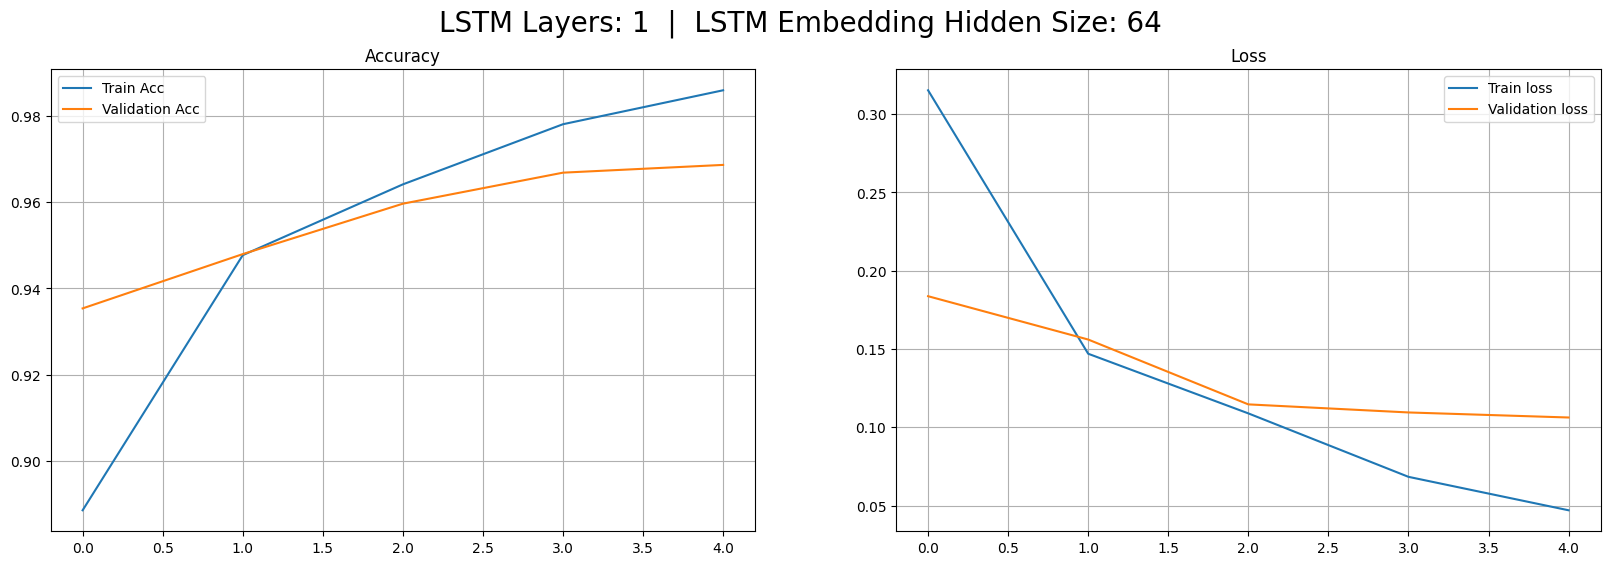

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 6))
# add header for hyperparameters
plt.suptitle('LSTM Layers: 1  |  LSTM Embedding Hidden Size: 64', fontsize=20)
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score

model.eval()
all_logits, all_labels = [], []
with torch.no_grad():
    for X, y in valid_loader:
        X, y = X.to(device), y.to(device).long()
        h = model.init_hidden(X.size(0))
        logits, _ = model(X, h)
        all_logits.append(logits.cpu())
        all_labels.append(y.cpu())

y_true  = torch.cat(all_labels).numpy()
y_score = torch.sigmoid(torch.cat(all_logits)).numpy()

roc_auc = roc_auc_score(y_true, y_score)
pr_auc  = average_precision_score(y_true, y_score)

best = {"thr": 0.5, "f1": -1}
for thr in np.linspace(0.05, 0.95, 19):
    y_pred = (y_score >= thr).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    if f1 > best["f1"]:
        best.update({"thr": thr, "f1": f1})

print(f"ROC-AUC: {roc_auc:.3f}  PR-AUC: {pr_auc:.3f}")
print(f"Best-F1 threshold: {best['thr']:.2f},  F1={best['f1']:.3f}")


ROC-AUC: 0.964  PR-AUC: 0.930
Best-F1 threshold: 0.60,  F1=0.885


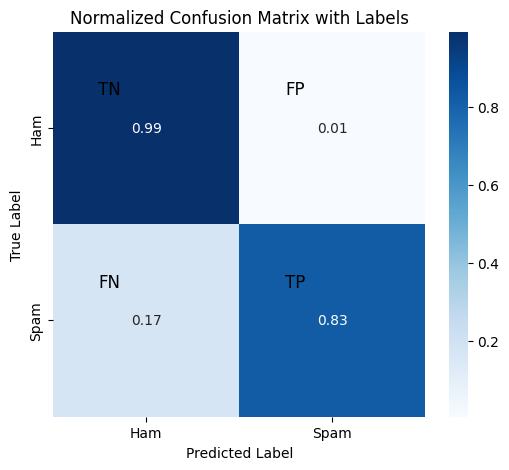

Final @thr=0.6:  Precision=0.953  Recall=0.826  F1=0.885
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       961
           1       0.95      0.83      0.88       149

    accuracy                           0.97      1110
   macro avg       0.96      0.91      0.93      1110
weighted avg       0.97      0.97      0.97      1110



In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

thr = 0.60
y_pred = (y_score >= thr).astype(int)

prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
cm = confusion_matrix(y_true, y_pred, normalize='true')
# Create the heatmap
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                 xticklabels=['Ham', 'Spam'],
                 yticklabels=['Ham', 'Spam'])

# Add TP, FP, FN, TN labels manually
plt.text(0.3, 0.3, 'TN', ha='center', va='center', color='black', fontsize=12)
plt.text(1.3, 0.3, 'FP', ha='center', va='center', color='black', fontsize=12)
plt.text(0.3, 1.3, 'FN', ha='center', va='center', color='black', fontsize=12)
plt.text(1.3, 1.3, 'TP', ha='center', va='center', color='black', fontsize=12)

plt.title('Normalized Confusion Matrix with Labels')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(f"Final @thr={thr}:  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}")
print(classification_report(y_true, y_pred))


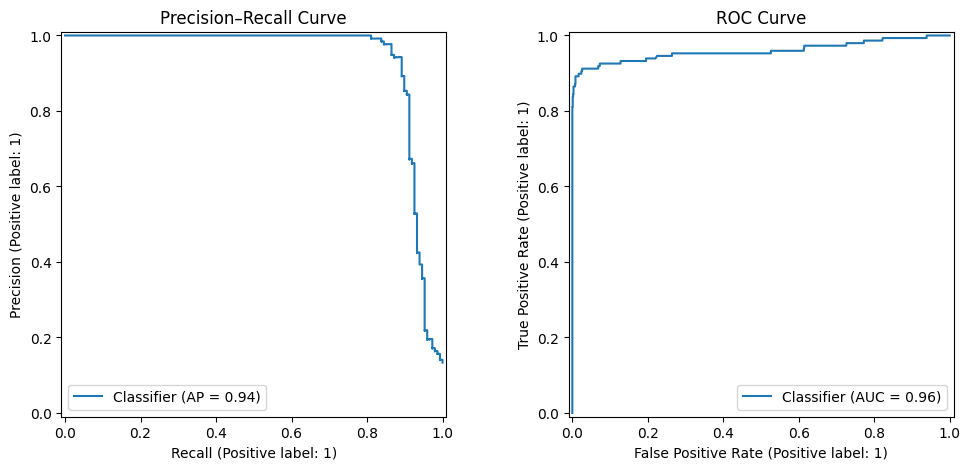

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
PrecisionRecallDisplay.from_predictions(y_true, y_score, ax=axs[0])
axs[0].set_title("Precision–Recall Curve")

RocCurveDisplay.from_predictions(y_true, y_score, ax=axs[1])
axs[1].set_title("ROC Curve")

plt.show()


## Neural Network For NLP Using GloVe Embeddings

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Hugging Face datasets + TF tokenizer (for simple word-index)
from datasets import load_dataset
import tensorflow as tf

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 64
EPOCHS = 30
LR = 1e-3
EMBED_DIM = 50
# Path to your GloVe file (change if needed)
GLOVE_PATH = "glove.6B.50d.txt"

In [ ]:
# helper functions
def load_vectors(fname):
    embedding_dict = {}
    with open(fname, "r", encoding="utf8") as f:
        for line in f:
            parts = line.rstrip("\n").split(" ")
            word = parts[0]
            vec = np.asarray(parts[1:], dtype="float32")
            embedding_dict[word] = vec
    return embedding_dict

def create_embedding_matrix(word_index, embedding_dict, embed_dim=300):
    # +1 because Keras word_index is 1-based and reserves 0 for padding
    mat = np.zeros((len(word_index) + 1, embed_dim), dtype="float32")
    for word, idx in word_index.items():
        vec = embedding_dict.get(word)
        if vec is not None:
            mat[idx] = vec
    return mat

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, i):
        x = self.sequences[i]
        y = self.labels[i]
        return {
            "review": torch.tensor(x, dtype=torch.long),
            "target": torch.tensor(y, dtype=torch.float32),
        }


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_matrix, freeze=True, hidden_dim=128):
        super().__init__()
        num_words, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(num_embeddings=num_words, embedding_dim=embed_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = not freeze

        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        # mean pool (2*hidden), max pool (2*hidden) -> concat = 4*hidden
        self.out = nn.Linear(4 * hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        avg_pool = torch.mean(x, dim=1)
        max_pool, _ = torch.max(x, dim=1)
        out = torch.cat([avg_pool, max_pool], dim=1)
        out = self.out(out)  # logits
        return out

In [ ]:
# train and evaluate
def train_one_epoch(loader, model, optimizer, device):
    model.train()
    loss_fn = nn.BCEWithLogitsLoss()
    for batch in loader:
        reviews = batch["review"].to(device)
        targets = batch["target"].to(device).view(-1, 1)

        optimizer.zero_grad()
        logits = model(reviews)
        loss = loss_fn(logits, targets)
        loss.backward()
        optimizer.step()

def evaluate(loader, model, device):
    model.eval()
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            reviews = batch["review"].to(device)
            targets = batch["target"].cpu().numpy().tolist()
            logits = model(reviews).cpu().numpy().ravel()
            all_logits.extend(logits)
            all_targets.extend(targets)
    # Convert logits -> probabilities -> binary preds
    probs = 1 / (1 + np.exp(-np.array(all_logits)))
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(all_targets, preds)
    f1 = f1_score(all_targets, preds)
    cm = confusion_matrix(all_targets, preds, normalize='true')
    return acc, f1, cm

In [ ]:
def run():
    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # Load dataset
    ds = load_dataset("ucirvine/sms_spam")  # typically only 'train' split
    df = ds["train"].to_pandas()

    # Infer text/label columns
    # Common schema for this dataset: 'sms' (text) and 'label' (0=ham, 1=spam) or 'ham'/'spam' strings.
    possible_text_cols = ["sms", "text", "message", "review"]
    possible_label_cols = ["label", "target", "sentiment", "class", "spam"]

    text_col = next((c for c in possible_text_cols if c in df.columns), None)
    label_col = next((c for c in possible_label_cols if c in df.columns), None)
    if text_col is None or label_col is None:
        raise ValueError(f"Could not find text/label columns. Found: {list(df.columns)}")

    # Normalize labels to {0,1}
    y_raw = df[label_col]
    if y_raw.dtype == object:
        # string labels like "spam"/"ham"
        y = y_raw.str.lower().map({"ham": 0, "spam": 1}).astype(int).values
    else:
        # already numeric
        y = y_raw.astype(int).values

    X_text = df[text_col].astype(str).values

    # Split
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_text, y, test_size=0.2, stratify=y, random_state=42
    )

    # Tokenizer with OOV token so index 1 == "unknown", 0 == padding
    tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train.tolist())

    X_train_seq = tokenizer.texts_to_sequences(X_train.tolist())
    X_valid_seq = tokenizer.texts_to_sequences(X_valid.tolist())

    X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(
        X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post"
    )
    X_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(
        X_valid_seq, maxlen=MAX_LEN, padding="post", truncating="post"
    )

    # Embeddings
    print("Loading GloVe from:", GLOVE_PATH)
    if not os.path.exists(GLOVE_PATH):
        raise FileNotFoundError(
            f"GloVe file not found at {GLOVE_PATH}. Download glove.6B.300d.txt and update GLOVE_PATH."
        )
    emb_dict = load_vectors(GLOVE_PATH)
    emb_matrix = create_embedding_matrix(tokenizer.word_index, emb_dict, embed_dim=EMBED_DIM)

    # Datasets & loaders
    train_ds = TextDataset(X_train_pad, y_train)
    valid_ds = TextDataset(X_valid_pad, y_valid)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=0)

    # Model
    model = LSTMModel(emb_matrix, freeze=True, hidden_dim=128).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

    # Train loop with simple early stop
    best_f1 = 0.0
    patience = 2
    bad = 0
    metric = {}
    for epoch in range(1, EPOCHS + 1):
        train_one_epoch(train_loader, model, optimizer, device)
        acc, f1, cm = evaluate(valid_loader, model, device)
        metric[epoch] = {"acc": acc, "f1": f1, "cm": cm}
        print(f"Epoch {epoch:02d} | val_acc={acc:.4f} | val_f1={f1:.4f} | cm = {cm}")

        if f1 > best_f1:
            best_f1 = f1
            bad = 0
        else:
            bad += 1
            if bad > patience:
                print("Early stopping.")
                break
    return metric

In [ ]:
metric = run()

Device: cuda
Loading GloVe from: glove.6B.50d.txt
Epoch 01 | val_acc=0.9677 | val_f1=0.8800 | cm = [[0.98033126 0.01966874]
 [0.11409396 0.88590604]]
Epoch 02 | val_acc=0.9722 | val_f1=0.8956 | cm = [[0.98447205 0.01552795]
 [0.10738255 0.89261745]]
Epoch 03 | val_acc=0.9767 | val_f1=0.9133 | cm = [[0.98550725 0.01449275]
 [0.08053691 0.91946309]]
Epoch 04 | val_acc=0.9812 | val_f1=0.9273 | cm = [[0.99378882 0.00621118]
 [0.10067114 0.89932886]]
Epoch 05 | val_acc=0.9848 | val_f1=0.9428 | cm = [[0.99171843 0.00828157]
 [0.06040268 0.93959732]]
Epoch 06 | val_acc=0.9848 | val_f1=0.9428 | cm = [[0.99171843 0.00828157]
 [0.06040268 0.93959732]]
Epoch 07 | val_acc=0.9839 | val_f1=0.9384 | cm = [[0.99378882 0.00621118]
 [0.08053691 0.91946309]]
Epoch 08 | val_acc=0.9812 | val_f1=0.9293 | cm = [[0.98964803 0.01035197]
 [0.0738255  0.9261745 ]]
Early stopping.


Accuracy: 0.9848 | F1 Score: 0.9428


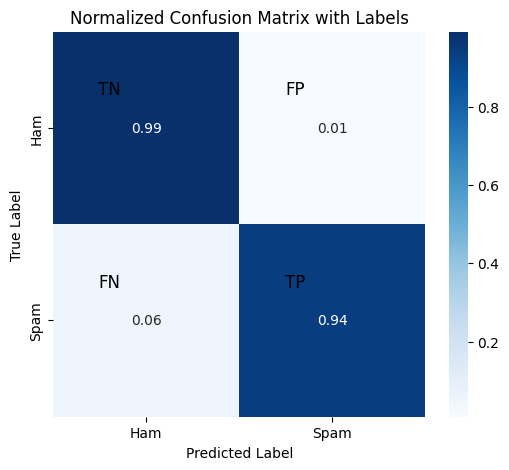

In [ ]:
best_epoch = 5
acc = metric.get(best_epoch).get('acc')
F1 = metric.get(best_epoch).get('f1')
print(f"Accuracy: {acc:.4f} | F1 Score: {F1:.4f}")
cm = metric.get(best_epoch).get('cm')
# Create the heatmap
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                 xticklabels=['Ham', 'Spam'],
                 yticklabels=['Ham', 'Spam'])

# Add TP, FP, FN, TN labels manually
plt.text(0.3, 0.3, 'TN', ha='center', va='center', color='black', fontsize=12)
plt.text(1.3, 0.3, 'FP', ha='center', va='center', color='black', fontsize=12)
plt.text(0.3, 1.3, 'FN', ha='center', va='center', color='black', fontsize=12)
plt.text(1.3, 1.3, 'TP', ha='center', va='center', color='black', fontsize=12)

plt.title('Normalized Confusion Matrix with Labels')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()